In [1]:
import math
import time
import json
import scipy
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,5))

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

In [35]:
df = pd.read_pickle('../data/shippify_icd_new.pkl', compression='gzip')
df = df.dropna(subset=['pickup_effective_dt', 'delivery_effective'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226828 entries, 0 to 251822
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   id                   226828 non-null  object             
 1   route_id             223343 non-null  object             
 2   creation_date        226828 non-null  datetime64[ns, UTC]
 3   delivery_type        226828 non-null  object             
 4   city                 226828 non-null  int8               
 5   cost                 226828 non-null  float64            
 6   total_size           226828 non-null  int64              
 7   distance             226828 non-null  float64            
 8   company_id           226828 non-null  int64              
 9   company_type         226828 non-null  int64              
 10  network_id           226828 non-null  int16              
 11  pickup_dt            226828 non-null  datetime64[ns, UTC]
 12  pi

### **Agregar codigo necesario debajo de su nombre**

## Enmanuel Magallanes

In [137]:
def set_labels(title=None, x_label=None, y_label=None, fontsize=14, legend=None):
  if title is not None:
    plt.title(title, fontsize=fontsize)
  if x_label is not None:
    plt.xlabel(x_label, fontsize=fontsize)
  if y_label is not None:
    plt.ylabel(y_label, fontsize=fontsize)
  if legend is not None:
    legend['object'].set_title('Delivery time')
    new_labels = ['Late', 'At time']
    for t, l in zip(legend['object'].texts, new_labels): t.set_text(l)

def with_hue(plot, feature, categories, hue_categories):
  a = [p.get_height() for p in plot.patches]
  patch = [p for p in plot.patches]
  for i in range(categories):
    total = a[i] + a[i+categories]
    for j in range(hue_categories):
      percentage = '{:.1f}%'.format(100 * a[(j*categories + i)]/total)
      x = patch[(j*categories + i)].get_x() + patch[(j*categories + i)].get_width() / 2 - 0.15
      y = patch[(j*categories + i)].get_y() + patch[(j*categories + i)].get_height() 
      plt.annotate(percentage, (x, y), size = 12)
  plt.show()

In [ ]:
## Question: cual son las franjas horarias en las que se regitran mas tareas atrasadas y de que (tipo|peso) son?
## Question: Are the heaviest tasks the ones that register the most delays at the time of delivery?

In [40]:
def sum_total_weight(row):
  items = json.loads(row)
  total_weight = 0
  for item in items:
    try:
      weigth = item['weight']
      if weigth == 'NaN':
        total_weight += 0
      else:
        total_weight += float(weigth)
    except:
      total_weight += 0
  return total_weight
df['total_weight'] = df['items'].apply(sum_total_weight)

# Remove outlayers using the z-score
z_scores = stats.zscore(df['total_weigth'])
abs_z_scores = np.abs(z_scores)
filtered_entries = abs_z_scores < 3
#df = df[ filtered_entries ]

labels = ['[0,0.5) kg', '[0.5,1) kg', '[1,1.5) kg', '[1.5,2) kg', '[2,2.5) kg', '[2.5,3) kg', '[3,3.5) kg', '[3.5 kg,inf) kg']
df['class_weight'] = pd.cut(df['total_weight'], bins=[0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, np.inf], labels=labels, include_lowest=True)

In [83]:
size_dict = { 1: 'X Small', 2: 'Small', 3: 'Medium', 4: 'Large', 5: 'X Large' }

In [85]:
df['total_size'] = df['total_size'].apply(lambda size: size_dict.get(size, 3))

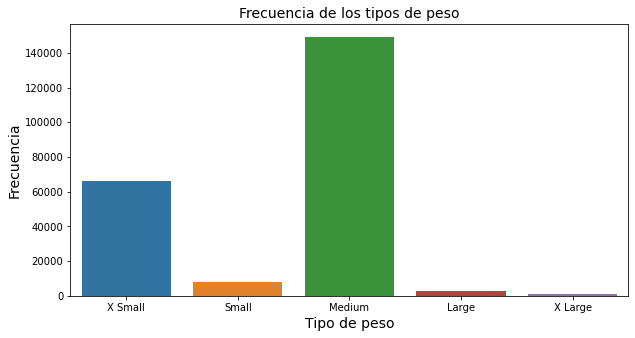

In [138]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='total_size', order=size_dict.values())
set_labels('Frecuencia de los tipos de peso', 'Tipo de peso', 'Frecuencia')

In [93]:
# Add column to mark task that was deliveried with delay
df['is_late'] = df['delivery_dt'] < df['delivery_effective']

In [95]:
gwl = df[['id', 'total_size', 'is_late']].groupby(['total_size', 'is_late'])['id'].count().reset_index()

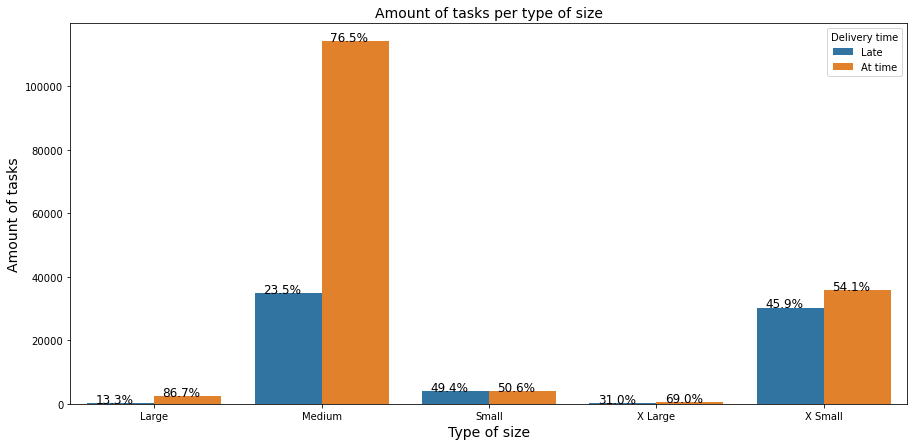

In [139]:
plt.figure(figsize=(15,7))
f = sns.barplot(data=gwl, x='total_size', y='id', hue='is_late')
set_labels(
  'Amount of tasks per type of size', 'Type of size', 'Amount of tasks', 
  legend={'object': f.get_legend(), 'title': 'Delivery time', 'texts': ['Late', 'Not late']
})
with_hue(f, df['total_size'], 5, 2)

A primera vista, el porcentaje de paquetes retrasados no es ni directa ni directamente proporcional al peso. Esto debido a que no se registra un aumento o disminución en el porcentaje de paquetes con atrasos, conforme aumenta su peso. Por tanto, el peso total de la entrega no afecta a la puntualidad de la misma.


In [ ]:
## Question 2: La intensidad del trafico en el punto destino de una entrega influje en la puntualidad de la misma?
## cantidad de entregas en un radio específico
## considerar la densidad de entregas en un radio especifico, en una ventana de tiempo. 
# Basado en lat.long un radio de X km y basado en delivery date una ventana de X horas, cuantas entregas hay
## considerar cuantas entregas fueron creadas ese día en esa ciudad

In [ ]:
def haversine_distance(x, y):
  """
  Calculate the great circle distance between two points
  on the earth (specified in decimal degrees)
  """
  # convert decimal degrees to radians
  lon1, lat1, lon2, lat2 = map(math.radians, [x[0], x[1], y[0], y[1]])

  # haversine formula
  dlon = lon2 - lon1
  dlat = lat2 - lat1
  a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
  c = 2 * math.asin(math.sqrt(a))
  R = 6371
  return R * c

In [ ]:
def calcualte_distance(point, dataframe):
  return dataframe.apply(
    lambda row: haversine_distance((row['lon'], row['lat']), point),
    axis=1
  )

In [ ]:
def task_around(row):
  diffs = row['delivery_dt'] - df['delivery_effective']
  diffs = diffs.apply(lambda x: abs(x.total_seconds())) / 3600
  df = df[ diffs <= WINDOW_TIME ]
  distances = calcualte_distance(
    (row['lon'], row['lat']),
    df[['lon', 'lat']]
  )

  distances_filt = distances <= KMS_AROUND


In [ ]:
KMS_AROUND = 10
WINDOW_TIME = '2H'
df.apply(task_around, axis=1)

### Hour late vs Total weight

In [ ]:
diff = df['delivery'] - df['delivery_effective']
df['delay_delivery'] = diff.apply(lambda x: abs(int(x.total_seconds()))) / 3600

## Josue Cobos

In [ ]:
#Question: Are those deliveries that are further from the economic center of Belo Horizonte those with the longest delivery delay?

In [ ]:
#calculate distance between 2 lat long points
def calculateDistance(point, anotherPoint):
    lat1, lon1 = point
    lat2, lon2 = anotherPoint 
    R = 6373.0
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance #kilometers

In [ ]:
#For this question we will assume Barreiro in the most important regional administration of Belo Horizonte
BARREIROPOINT = (-19.977, -44.0145)
def getDistanceFromA(row):
  #print(row)
  return calculateDistance(BARREIROPOINT, (row['lat'], row['long']))
  #return row #distance

In [ ]:
df['dst_to_barreiro'] = df[['lat', 'long']].apply(getDistanceFromA, axis=1)

In [ ]:
plt.figure(figsize=(15,7))
subdf = df[['dst_to_barreiro','delay_delivery']]
f2 = sns.scatterplot(x=subdf['dst_to_barreiro'], y=subdf['delay_delivery'])
#with_hue(f, df.class_weight, 8, 2)

In [ ]:
subdf.corr()

In [ ]:
#Answer: Due to the non-existent correlation between the delay of shipments (delay_delivery) and distance to Barreiro (dst_to_barreiro), we can conclude that no matter how far your order is, it does not necessarily mean that it has a longer delay time.